<span style="color:####; font-family: sabon; font-size: 3em;">
    <center> Logistic Regression </center> <br>
</span>

<span style="color:####; font-family: sabon; font-size: 2.5em;">
   <center> Machine Learning </center> <br>
    <center> Kevin Emmanuel Soto Hernandez </center> <br>
</span>

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import matplotlib.image as mpimg
import numpy as np
import sys
%matplotlib inline

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [468]:
def progressBar(value, endvalue, bar_length=20):

        percent = float(value) / endvalue
        arrow = '-' * int(round(percent * bar_length)-1) + '>'
        spaces = ' ' * (bar_length - len(arrow))

        sys.stdout.write("\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
        sys.stdout.flush()

**Ejercicio 1.** Implemente en Python algoritmos para resolver la regresi´on logística
$$ \hat{y_i} = \sigma( w^Tx_i) = \frac{1}{ 1+ exp(-w^Tx_i)} $$
para datos $x_i = (1, x_i) \in \mathbb{R}^{n+1}$, $y_i\in \{0,1\}$, y vector de parámetros $w = (w_0, w_1, \dots , w_n) \in \mathbb{R}{n+1}$ mediante la siguiente estrategia:

Maximizando la verosimilitud conrespecto al vector de pesos $w$:
$$ \max \limits_w p(y|w) = \prod \limits_{i=1}^n \sigma_i^{y_i} (1 -\sigma_i)^{1-y_i}  $$
donde $ y= (y_1, y_2, \dots, y_n)^T$
Adicionalmente, implemente una función ``predict`` que, dado un juego de datos ``X``, prediga las etiquetas $\hat{y}$ usando su modelo de regresión logística.

_------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------_

Como es usual, definimos una función de error tomando el logaritmo negativo de la función de verosimilitud, lo cual da la función de cross-entropy en la forma:

$$E(w) = -ln p(y|w) = - \sum \limits_{i=1}^n y_i ln \sigma_i + (1-y_i) ln (1-\sigma_i) $$

donde $\sigma_i = \sigma(w^Tx_i)$.

Esta función será la que tomaremos para optimizar nuestro vector de pesos $w$. Note que el mismo vector $w^*$ es aquel que maximizan la verosimil. Calculando el gradiente de la función de error con respecto a $w$ obtenemos:

$$\nabla E(w) = -\sum \limits_{i=1}^n \frac{y_i}{\sigma_i} \sigma_i (1-\sigma_i)x_i - \frac{1-y_i}{1-\sigma_i} \sigma_i (1-\sigma_i)x_i$$

$$ \nabla E(w) = -\sum \limits_{i=1}^n y_ix_i - \sigma_i x_i  $$
$$ \nabla E(w) = \sum \limits_{i=1}^n (\sigma_i - y_i) x_i  $$

donde hemos usado el hecho de que $$\frac{d\sigma}{dw} = \sigma(1-\sigma)x_i$$. 

En particular, la contribución al gradiente por el punto $x_i$ en los datos viene dada por el "error" $\sigma_i - y_i $ entre el valor de la etiqueta y la predicción del modelo. 
Podríamos utilizar el resultado anterior para dar un algoritmo secuencial en el que cada uno de los vectores de peso se actualiza usando:

$$ w_{k+1} = w_k - \alpha \nabla E(w_k) $$

siguiendo el descenso de gradiente simple. Pero nosotros optamos por otra medida más óptima e implementaremos la modificación con Nesterov. 

Primero definimos la función sigmoide y la funcion de error cuadrático.

In [59]:
def sigmoid(x):
    '''
    Función sigmoide 
    
    Parámetro
    ----------- 
    x : float
    
    Regresa
    -----------
    El valor la función sigmoide evaluado en x 
    '''
    return 1/(1 + np.exp(-x))

In [525]:
def error(w, X, y):
    '''
    Función de error cuadrático
    
    Parámetro
    ----------- 
    w  :  1-D numpy array de dimensión (d+1)x1 (vector de pesos)
    X  :  2-D numpy array de dimensión nx(d+1) (matriz de datos)
    y  :  1-D numpy array de dimensión nx1 (vector de etiquetas)
    
    Regresa
    -----------
    El valor de la suma del erro cuadrado en la predicción evaluado en w 
    '''
    n, d = X.shape
    E = 0 #solo para inicializar el valor
    for i in range(n): #iteramos sobre las etiquetas
        E +=  (y[i] - sigmoid(np.dot(w, X[i,:])) )**2
    return E

Después una función que regrese el gradiente de la función cross-entropy que puede ser evaluado en cualquier punto $w_k$

In [503]:
def grad(w, X, y):
    '''
    Gradiente de la función -ln(p(y|w)) "Cross-Entropy"
    
    Parámetros
    -----------
    w  :  1-D numpy array de dimensión (d+1)x1 (vector de pesos)
    X  :  2-D numpy array de dimensión nx(d+1) (matriz de datos)
    y  :  1-D numpy array de dimensión nx1 (vector de etiquetas)
    
    Regresa
    -----------
    En  :  1-D numpy array de dimensión rxm
    '''
    n, d = X.shape
    En = np.zeros(d) #solo para inicializar el vector
    for i in range(n): #iteramos sobre las etiquetas
        En += ( sigmoid(np.dot(w, X[i,:])) - y[i] ) * X[i,:]
    return En

Aplicar el algoritmo descenso de gradiente versión Nesterov es relativamente sencillo en este punto. Proponemos dos criterios de parada del algoritmo: 1) la norma del gradiente debe de ser menor a una tolerancia $\lVert \nabla E(w) \rVert < \epsilon$; 2) un número máximo de iteraciones (``max_iter = 50`` por defecto para evitar el overfitting).

In [555]:
def GDNesterov(X, y, alpha = 1e-5, epsilon = 1e-3, eta = 2, max_iter = 50):
    """
    Descenso de Gradiente Nesterov
    
    Parámetros
    -----------
    X  :  2-D numpy array de dimensión (n+1)x1 (matriz de datos)
    y  :  1-D numpy array de dimensión nx1 (vector de etiquetas)
    alpha :  int - tamaño de paso
    epsilon : int - parámetro de parada del gradiente
    eta : int - parametro del Nesterov
    max_iter : int - número maximo de iterciones antes de detener el algoritmo.
    
    Regresa
    -----------
    w  :  1-D numpy array de dimensión dx1 (vector de pesos)
    """
    iter = 0
    
    #vector de pesos inicializado aleatoriamente.
    w = np.random.rand(X.shape[1])
    
    # Optimización
    while(True):
        iter+=1
        Grad = grad(w,X,y)
        
        # Nesterov
        w = w - alpha*( grad(w-2*alpha*Grad, X, y) + (eta+1)*Grad )
        
        # Gradiente Simple
        #w = w - alpha*Grad 
        
        if iter > max_iter or np.linalg.norm(Grad) < epsilon: 
            break
    return w

Finalmente implementamos una función general para la regresión logistica que recibe una matriz de datos ``X`` con los datos $x_i$ componiendo las filas de la matriz; y un vector ``y`` con las etiquetas respectivas de cada dato. Esta función agrega a la matriz de datos una columna de $1$'s (correspondientes al valor del peso $w_0$). Despues, usa el algoritmo de Nesterov para calcular el vector de pesos que minimizan la función de verosimiltud, y con éstos predice las etiquetas del modelo de clasificación en la función ``predict`` (la función ``predict`` se implementa primero antes de ``Logistic_Regression`` por conveniencia en la secuencialidad del código).  

In [155]:
def predict(w, X):
    '''
    Función de predicción de clases con Logistic_Regression
    
    Parámetros
    -----------
    w  : 1-D numpy array (vector de pesos obtenidos de Logistic_Regression)
    X  : 2-D numpy array (matriz de datos a asignar las etiquetas)
    
    Regresa
    -----------
    predictions : 1-D numpy array (vector con las predicciones de las clases para los datos x_i)
    '''
    predictions = sigmoid(np.sum(X*w, axis=1))
    predictions[predictions <= 0.5] = 0
    predictions[predictions > 0.5] = 1
    return predictions.astype(int)

In [551]:
def Logistic_Regression(X, y, alpha = 1e-3, max_iter = 50):
    '''
    Regresión Logística
    
    Parámetros
    -----------
    X  :  2-D numpy array de dimensión (n+1)x1 (matriz de datos)
    y  :  1-D numpy array de dimensión nx1 (vector de etiquetas)
    
    Regresa
    -----------
    predictions : 1-D numpy array (vector con las predicciones de las clases para los datos x_i)
    w  : 1-D numpy array (vector de pesos obtenidos de Logistic_Regression)
    '''
    n, d = X.shape
    if (n,) != y.shape: 
        print("Dimensiones de datos no corresponde a dimension de las etiquetas")
        return None
    X = np.append(np.ones(n).reshape(n,1), X, axis = 1)
    w = GDNesterov(X, y, alpha, max_iter=max_iter)
    predictions = predict(w, X)
    return (predictions, w/np.linalg.norm(w))

**Ejercicio 2.** Considere de nuevo la base de datos MNIST. Elija dos dígitos distintos entre 0 y 9 (a su gusto), y tome 1200 imágenes del primer dígito, y 1200 imágenes del segundo dígito. De cada grupo, separe 1000 para entrenamiento y 200 para validación.
Re-utilizando su código de la tarea 1, construya una matriz no negativa de 2000 columnas, Sea
A 2 R784×2000 a partir de las 2000 im´agenes elegidas. Luego, encuentre una descomposición NNMF

$$A=WH$$

con $W \in \mathbb{R}^{784×r}$, $H \in \mathbb{R}^{r×2000}$, matrices no-negativas.

Las 2000 columnas de la $H$ obtenida, corresponderán a vectores característicos $x_i \in \mathbb{R}^r$ de cada una de las imágenes elegidas $1 ≤ i ≤ 2000$, pero ahora en un espacio de dimensión menor $r << 784$. Tome como caso base $r = 20$.
* Utilice estos vectores $x_i$ como las entradas de su clasificador de regresión logística.
* Calcule métricas de desempeño (las que considere convenientes), tanto para el conjunto de entrenamiento como para el de validación.
* Repita esto un cierto número de veces, tomando en cada caso, una muestra diferente de las 2000 imágenes (mismos dígitos, diferentes muestras de imágenes). ¿Varía el error de entrenamiento? ¿Y el de validación? ¿Cuánto?
* Elabore gráficas del desempeño de su métodos, y gráficas del resultado de la clasificación (ejemplos de falsos positivos y falsos negativos, si es el caso). Discuta sus resultados.

_------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------_

``X_train`` es un 3-D numpy array de dimensiones $(6000,28,28)$ con todas las imagenes de los digitos del 0 al 9 mezcladas, mientras que ``y_train`` es un 1-D numpy array que contiene sus etiquetas respectivas. Podemos usar estos arreglos para muestrear $1200$ imágenes del dígito $0$ y $7$. En adición se crean sus vector de etiquetas.

In [200]:
#Tensor de imagenes del dígito 0
D0 = X_train[y_train==0]
D0 = D0[:1200]
y0 = np.zeros(1000, dtype=int)

#Tensor de imagenes del dígito 7
D7 = X_train[y_train==7]
D7 = D7[:1200]
y7 = np.ones(1000, dtype=int)

El tensor `D0` contiene $1200$ imagenes del digito $0$ cuya etiqueta asignada es $0$

El tensor `D7` contiene $1200$ imagenes del digito $7$ cuya etiqueta asignada es $1$

Ahora, definimos una función que imprime la imagen del dígito a tráves de su matriz de calor para comprobar que el indexado fue hecho de manera correcta (tambien mostramos su etiqueta respectiva).

In [497]:
def visualizar_imagen(matrix):
    '''
    Para visualizar en imagen el expectro de calor de una matriz
    
    Parámetros
    -----------
    matrix   :  2-D numpy array 
    
    Regresa
    -----------
    Imprime imagen de la matriz
    '''
    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111)
    ax.imshow(matrix, origin="upper", interpolation="gaussian")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)

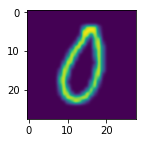

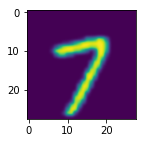

In [162]:
visualizar_imagen(D0[194]) 
visualizar_imagen(D7[194]) 

In [163]:
y0[194], y7[194]

(0, 1)

La siguiente función separa un base de datos en una array de tamaño ``num_sample`` y otro de tamaño ``num_data - num_samples`` que corresponden a los datos de entrenamiento y datos de validación respectivamente. Para el caso con nuestra matriz de digitos: ``num_data=1200`` y ``num_samples=1000``. 

In [256]:
def sample_data(X, num_samples):
    num_data = X.shape[0]
    if num_samples >= num_data: return X, None
    
    sample = np.random.choice(num_data, num_samples, replace=False)
    Xtrain = X[sample]
    Xtest = X[np.setdiff1d(np.arange(0,num_data),sample)]
    return Xtrain, Xtest

In [543]:
#Datos del digito 0
D0train, D0test = sample_data(D0, 1000)
y0train = np.zeros(1000, dtype=int)
y0test = np.zeros(200, dtype=int)

#Datos del digito 7
D7train, D7test = sample_data(D7, 1000)
y7train = np.ones(1000, dtype=int)
y7test = np.ones(200, dtype=int)

Para transformar nuestro 3-D array en una matriz de datos adecuada para los métodos a usar, construimos la función ``tensor_to_matrix`` que toma como argumento un tensor de dimensión $(n,m,k)$ (la base de datos mnist está organizada en un 3-D array) y regresa un 2-D array de dimensión $(mk,n)$  en donde cada columna se compone de los sub 2-D arrays vectorizados. Es decir, los estira y despues los apila en una matriz.

In [544]:
def tensor_to_matrix(tensor):
    '''
    Transforma un tensor de n x m x k en una matriz m*k x n
    
    Parámetros
    -----------
    tensor  :  3-D numpy array de dimensión n x m x k
    
    Regresa
    -----------
    matrix  :  2-D numpy array de dimensión m*k x n
    '''
    n, m, k = tensor.shape
    matrix = np.reshape(tensor[0],(m*k,1))
    for i in range(1,n):
        xcol = np.reshape(tensor[i], (m*k,1))
        matrix = np.column_stack((matrix, xcol))
    return matrix

Ahora, concatenamos ambas bases de datos ``D0train`` y ``D7train`` en una sola ``X`` para despues transformarla en una matriz de dimensión $(784,2000)$. Hacemos lo mismo para los datos de validacion.

In [545]:
#Datos de entrenamiento
Xtrain = tensor_to_matrix( np.vstack([D0train,D7train]) )
ytrain = np.append(y0train,y7train)

#Datos de validacion
Xtest = tensor_to_matrix( np.vstack([D0test,D7test]) )
ytest = np.append(y0test,y7test)

Para implementar el método de factorización de matrices no-negativas (NMF), basta llamar a la instrucción ``NMF`` de la librería ``sklearn.decomposition``. Probemos para una factorización con $r=20$

In [546]:
model = NMF(n_components = 20,init ='nndsvd', random_state=None, max_iter =10000)

W = model.fit_transform(Xtrain)
Htrain = model.components_

W = model.fit_transform(Xtest)
Htest = model.components_
Htest = np.append(np.ones(400).reshape(400,1),Htest.T, axis=1)

Lo que se desea con NMF es una reducción en la dimensionalidad de la matriz ``X``. En este caso, las $2000$ columnas de la matriz $H$ obtenida, corresponderán a vectores característicos $x_i \in \mathbb{R}^r$ que pueden ser usados en la regresión logística como sigue:

In [562]:
fit = Logistic_Regression(Htrain.T, ytrain, alpha = 1e-3, max_iter =50)
Htrain = np.append(np.ones(2000).reshape(2000,1),Htrain.T, axis=1)
print("Error cuadratico en la prediccion", error(fit[1], Htrain, ytrain) ) 

Error cuadratico en la prediccion 17.615622006285655


La gráfica de como luce la optimización de la función ``error``  para diferentes valores de ``alpha`` con Nesterov luce así:

![Grafica](graf.png)

Siendo ``alpha =1e-3`` el tamaño de paso con mejores resultados (este valor lo utilizaremos en el test estadistico). Finalmente medimos el porcentaje de clasificaciones bien hechas en ambos casos: datos de entrenamiento y datos de validación

In [405]:
def classification_accuracy(predict_labels, real_labels):
    vpos = (predict_labels == real_labels)
    return vpos[vpos==True].shape[0]/vpos.shape[0]

In [411]:
#exatitud del modelo en los datos de entrenamiento
print("% de aciertos en datos de entrenamiento: ",classification_accuracy(model[0], ytrain))

#exatitud del modelo en los datos de validación
predict_labels = predict(model[1],  Htest)
print("% de aciertos en datos de validación: ",classification_accuracy(predict_labels, ytest))

% de aciertos en datos de entrenamiento:  0.993
% de aciertos en datos de validación:  0.75


Los resultados parecen prometedores. Con unas cuantas iteraciones se alcanzo una exactitud muy cercana al 99% en los datos de validación y una exactitud del 80% en los datos de validación. Cabe destacar que se pudo fijar un máximo de iteraciónes más grande que 50 para así haber alcanzado un 100% de exactitud en la prediccion de los datos de entrenamiento; pero esto, de hecho, es contraproducente debido a que el modelo de clasificación con regresión logística estaría sobre-ajustado sólo a estos datos en específico (overfitting) alcanzando una exactitud promedio muy pobre del 62% porciento en los de validación. Para demostrar nuestro punto, hagamos un test estadístico tomando varias muestras aleatorias de la base de datos y replicando el experimento de clasificación con ``Logistic_regression``. Las condiciones del experimento se fijan así: dimensión de la descomposición NMF `r=10`; numero de muestras de cada dígito para los datos de validación `num_sample=1000`; máximo de iteraciones con optimizador Nesterov `max_iter=50`; número de experimentos independientes `num_test = 500`. Estos fueron los resultados:

In [498]:
def Tests_Logistic_Regression(num_test, num_sample=1000, r=20):
    num_data= 1200
    model = NMF(n_components = r, init ='nndsvd', random_state=None, max_iter =1000)
    validation = np.array([])
    training = np.array([])
    
    #Etiquetas de entrenamiento
    ytrain = np.append(np.zeros(num_sample, dtype=int), np.ones(num_sample, dtype=int))
    
    #Etiquetas de validación
    ytest = np.append(np.zeros(num_data-num_sample, dtype=int), np.ones(num_data-num_sample, dtype=int))
    
    for itest in range(num_test):
        progressBar(itest, num_test)
        #Muestreo
        D0train, D0test = sample_data(D0, num_sample)
        D7train, D7test = sample_data(D7, num_sample)
        
        #Datos de entrenamiento
        Xtrain = np.vstack([D0train,D7train])
        Xtrain = tensor_to_matrix(Xtrain)
        
        #Datos de validación
        Xtest = np.vstack([D0test,D7test])
        Xtest = tensor_to_matrix(Xtest)
        
        #Factorizacion no-negativa
        W = model.fit_transform(Xtrain)
        Htrain = model.components_

        W = model.fit_transform(Xtest)
        Htest = model.components_
        Htest = np.append(np.ones(2*(num_data-num_sample)).reshape(2*(num_data-num_sample),1), Htest.T, axis=1)
        
        #Regression Logistica
        fit = Logistic_Regression(Htrain.T, ytrain, max_iter =50)
        
        #exatitud del modelo en los datos de entrenamiento
        training = np.append(training, classification_accuracy(fit[0], ytrain))
        #exatitud del modelo en los datos de validación
        predict_labels = predict(fit[1],  Htest)
        validation = np.append(validation, classification_accuracy(predict_labels, ytest))
    
    progressBar(num_test, num_test)
    
    plt.title('Histograma de exactitud en datos de entrenamiento')
    plt.xlabel('% de exactitud')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.hist(training, range=(0,1), density=True, bins=50)
    plt.show()
    print("mejor : ", training.max())
    print("peor : ", training.min())
    print("media : ", round(training.mean(),4) )
    print("desv. est.: ", round(training.std(),4) )
    
    plt.title('Histograma de exactitud en datos de validación')
    plt.xlabel('% de exactitud')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.hist(validation, range=(0,1), density=True, bins=50, color='r')
    plt.show()
    print("mejor : ", validation.max())
    print("peor : ", validation.min())
    print("media : ", round(validation.mean(),4) )
    print("desv. est.: ", round(validation.std(),4) )

Percent: [------------------->] 100%

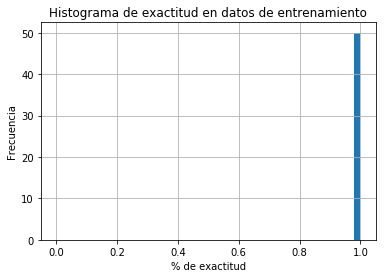

mejor :  0.997
peor :  0.9905
media :  0.9933
desv. est.:  0.0012


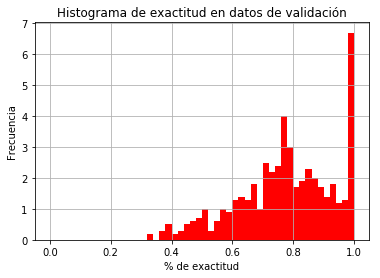

mejor :  0.9975
peor :  0.3275
media :  0.7736
desv. est.:  0.158


In [500]:
Tests_Logistic_Regression(500, 1000, 10)

Percent: [------------------->] 100%

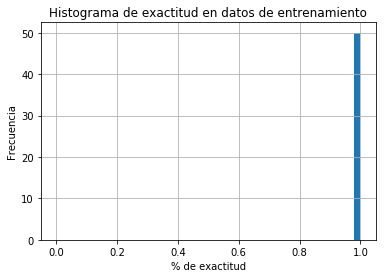

mejor :  0.9965
peor :  0.99
media :  0.9934
desv. est.:  0.0012


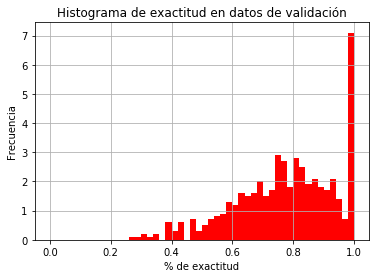

mejor :  1.0
peor :  0.2675
media :  0.7735
desv. est.:  0.1625


In [563]:
Tests_Logistic_Regression(500, 1000, 10)

Como pueden denotar los histogramas, en la mayoria de las veces el clasificador obtiene un predicción cercana al 99% en ambos casos; pero el promedio de nuestros experimentos se situa entre el 77% de exactitud; aun así, es un valor prometedor para una implementación sencilla de la regresión logística.